# Lab assignment: indoor image classification

<img src="img/indoor_outdoor.png" style="width:800px;">

In this assignment we will face an image classification problem, trying to tell apart images taken indoors from images taken on the outside. To do so we will use an SVM and a Deep Learning approach, comparing both methods.

## Guidelines

Throughout this notebook you will find empty cells that you will need to fill with your own code. Follow the instructions in the notebook and pay special attention to the following symbols.

<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td>You will need to solve a question by writing your own code or answer in the cell immediately below or in a different file, as instructed.</td></tr>
 <tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td>This is a hint or useful observation that can help you solve this assignment. You should pay attention to these hints to better understand the assignment.</td></tr>
 <tr><td width="80"><img src="img/pro.png" style="width:auto;height:auto"></td><td>This is an advanced and voluntary exercise that can help you gain a deeper knowledge into the topic. Good luck!</td></tr>
</table>

During the assigment you will make use of several Python packages that might not be installed in your machine. If that is the case, you can install new Python packages with

    conda install PACKAGENAME
    
if you are using Python Anaconda. Else you should use

    pip install PACKAGENAME

You will need the following packages for this particular assignment. Make sure they are available before proceeding:

* **numpy**
* **matplotlib**
* **scikit-learn**
* **keras**

The following code will embed any plots into the notebook instead of generating a new window:

In [67]:
import matplotlib.pyplot as plt
%matplotlib inline

Lastly, if you need any help on the usage of a Python function you can place the writing cursor over its name and press Caps+Shift to produce a pop-out with related documentation. This will only work inside code cells. 

Let's go!

## Preliminaries: data loading and image representation

In this assignment we will work with the images contained in the following folder:

In [68]:
datafolder = "./data/"

Two subfolders exist: one containing a range of indoor images and another one with outdoor images. We can load an image into python by making use of:

In [69]:
from scipy.misc import imread

path = datafolder + "indoor/1.jpg"
image = imread(path)

This returns the image as 3-dimensional numpy matrix, containing the value of intensity of every pixel in each row, column and color channel.

In [70]:
image.shape

(781, 1037, 3)

We can visualize the loaded image using

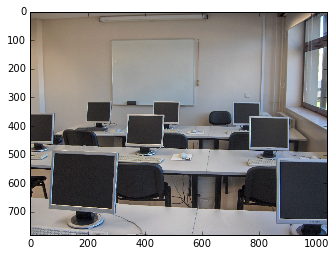

In [71]:
plt.imshow(image)

Note that the 3rd dimension of our image objects is the pixel intensity. This is divided into 3 **color channels**: those belonging to the red (R), green (G) and blue (B) intensities (**RGB** scheme). Each of these intensities ranges from 0 to 255, since these are 24-bit images: each of the 3 colors is represented by 8 bits, so they can range from 0 (all 8 bits set to 0) to 255 (all 8 bits set to 1). Let us define constants for this:

In [72]:
COLORS = ('r','g','b')
COLOR_MIN_VALUE = 0
COLOR_MAX_VALUE = 255
COLOR_NUM_VALUES = COLOR_MAX_VALUE - COLOR_MIN_VALUE + 1

When R, G and B are all zero, the pixel is totally black. When they are all 255, the pixel is totally white. Pure red is (255, 0, 0), pure green (0, 255, 0) and pure blue (0, 0, 255). Intermediate colors have intermediate values, according to what the specific pixel is. For example, let us manipulate the colors of the previous image:

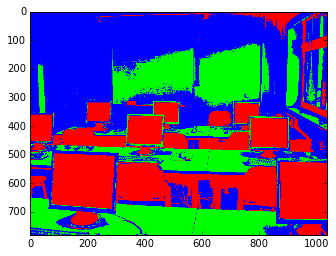

In [73]:
# Tolerance for white and black
tol = 100
white_end = tol - COLOR_MIN_VALUE
black_start = COLOR_MAX_VALUE - tol
# Copy image
image2 = image.copy()
# Set black pixels to pure red
black_pixels = (image[:, :, 0] <= white_end) & (image[:, :, 1] <= white_end) & (image[:, :, 2] <= white_end)
image2[black_pixels] = [COLOR_MAX_VALUE, COLOR_MIN_VALUE, COLOR_MIN_VALUE]
# Set white pixels to pure green
white_pixels = (image[:, :, 0] >= black_start) & (image[:, :, 1] >= black_start) & (image[:, :, 2] >= black_start)
image2[white_pixels] = [COLOR_MIN_VALUE, COLOR_MAX_VALUE, COLOR_MIN_VALUE]
# Set all the rest to pure blue
image2[~(black_pixels | white_pixels)] = [COLOR_MIN_VALUE, COLOR_MIN_VALUE, COLOR_MAX_VALUE]
# Plot result
plt.imshow(image2)

<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td>
Build a matrix *X* containing one row for each image in the data. Each row must contain the 3-dimensional matrix of pixels corresponding to an image. Build also a corresponding matrix *Y* with the class of each image (0 for indoor and 1 for outdoor).
 </td></tr>
</table>

<table align="left">
 <tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td>
Take advantage of the *glob* package to generate the filename lists for the indoor and outdoor subfolders.
 </td></tr>
</table>

In [8]:
import glob
indoor_files=glob.glob('./data/indoor/*.jpg')
outdoor_files=glob.glob('./data/outdoor/*.jpg')
print(len(indoor_files))
print(len(outdoor_files))
X=[]
y=[]
for file in indoor_files:
    X.append(imread(file))
    y.append(0)
for file in outdoor_files:
    X.append(imread(file))
    y.append(1)

171
200


If everything has been properly loaded both lists should have equal length

In [9]:
import numpy as np
print(len(X))
print(len(y))

# as the number of files is odd, we remove the last image from the dataset in order to 
# have exactly the same size in both training and test datasets

X.pop()
y.pop()

X=np.array(X)
y=np.array(y)



print(X.shape)
print(y.shape)



371
371
(370,)
(370,)


<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td>
Divide the data randomly into a training and a test set. Make sure that:
<ol>
<li>The training and test sets have the same size.</li>
<li>The proportion of indoor and outdoor images is the same inside the training and test sets.</li>
</ol>
 </td></tr>
</table>

<table align="left">
 <tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td>
The first requirement is trivial by halving the data. However, for the second requirement take into account that there are more outdoor than indoor images. This should still be the case after you partition the data. 
 </td></tr>
</table>

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)

for train_index, test_index in sss.split(X,y):
    X_train=X[train_index]
    y_train=y[train_index]
    X_test=X[test_index]
    y_test=y[test_index]

185
185
185
185


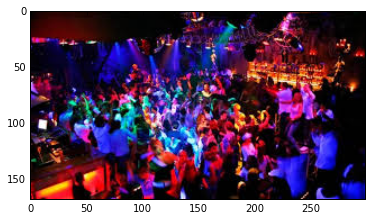

In [11]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

i=180
plt.imshow(X_train[i])


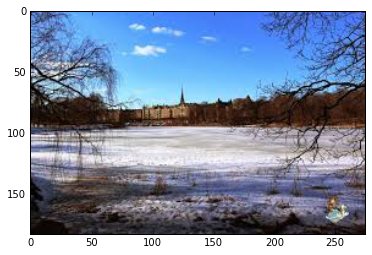

In [12]:
plt.imshow(X_test[i])

## Part 1: SVM approach

To be able to apply SVMs, we cannot work with 3-dimensional images as inputs. Instead, we should transform each of the *n* images into a *d*-dimensional vector, so that the pattern matrix *X* is a numpy matrix with shape (n, d).

It is not enough to collapse the 3-dimensions (height, width and color) into a vector, because not all images have the same height and width, so we would not obtain the same *d*. Somehow we need to obtain a vector of the same length for all images, regardless of their size. The color channel looks like a good candidate: it always has 3 subchannels (R, G, B) and the values of each of these subchannels are always in the range [0, 255].

The idea thus is to count how many times each value of R, G and B appears in the image, that is, getting a **color histogram**. Doing this separately for subchannel gives us a 256·3 = 768-dimensional vector. To keep counts in the same scale regardless of the image size, we can normalize these counts dividing them by their sum, obtaining **color frequencies**, so that the sum of all frequencies is 1.


<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td>
Implement a function *color_frequencies* that, given an image, returns the vector described.
 </td></tr>
</table>

<table align="left">
 <tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td>
Study carefully the documentation of numpy's <a href=http://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.histogram.html>histogram function</a>.
 </td></tr>
</table>

In [106]:
from numpy import histogram

def color_frequencies(img,norm=False):
       
        red=img[:, :, 0].ravel()
        green=img[:, :, 1].ravel()
        blue=img[:, :, 2].ravel()
        
        red_hist, bin_edges =histogram(red,256)
        green_hist, bin_edges=histogram(green,256)
        blue_hist, bin_edges=histogram(blue,256)
    
        color_hist=[]
        color_hist.append(red_hist)
        color_hist.append(green_hist)
        color_hist.append(blue_hist)
        
        color_hist=np.array(color_hist).ravel()
        
        color_hist_norm=[x/sum(color_hist) for x in color_hist]
        
        if(norm==True):
            result=color_hist_norm
        else:
            result=color_hist
        
        return result
        
color_frequencies(image)

array([  392,   173,   153,   208,   237,   303,   324,   365,   418,
         442,   474,   545,   536,   628,   695,   787,   832,   907,
        1002,  1149,  1150,  1255,  1535,  1677,  1916,  2201,  2613,
        2738,  3264,  3667,  4232,  4823,  5682,  6457,  7191,  7658,
        8517,  8805,  9027,  8947,  8678,  8465,  7708,  6990,  6576,
        6040,  5591,  5242,  5074,  4877,  4686,  4371,  4079,  3834,
        3517,  3114,  2740,  2314,  2025,  1771,  1494,  1341,  1098,
        1087,  1009,   965,   882,   923,   900,   874,   894,   890,
         819,   796,   827,   871,   855,   879,   872,   966,   960,
        1045,  1061,  1072,  1130,  1125,  1176,  1195,  1277,  1369,
        1396,  1436,  1478,  1419,  1460,  1480,  1550,  1508,  1561,
        1725,  1830,  1957,  2143,  2273,  2205,  2194,  2208,  2057,
        2042,  2015,  2079,  2139,  2167,  2269,  2293,  2468,  2529,
        2781,  2946,  3004,  3289,  3473,  3700,  3669,  3799,  3973,
        4049,  4115,

<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td>
Check the correctness of your implementation with the following code, which has the histogram for the image plotted above.
 </td></tr>
</table>

In [107]:
rgb_hist = [392, 173, 153, 208, 237, 303, 324, 365, 418, 442, 474, 545, 536, 628, 695, 787, 
              832, 907, 1002, 1149, 1150, 1255, 1535, 1677, 1916, 2201, 2613, 2738, 3264, 3667, 4232, 4823, 
              5682, 6457, 7191, 7658, 8517, 8805, 9027, 8947, 8678, 8465, 7708, 6990, 6576, 6040, 5591, 5242, 
              5074, 4877, 4686, 4371, 4079, 3834, 3517, 3114, 2740, 2314, 2025, 1771, 1494, 1341, 1098, 1087, 
              1009, 965, 882, 923, 900, 874, 894, 890, 819, 796, 827, 871, 855, 879, 872, 966, 
              960, 1045, 1061, 1072, 1130, 1125, 1176, 1195, 1277, 1369, 1396, 1436, 1478, 1419, 1460, 1480, 
              1550, 1508, 1561, 1725, 1830, 1957, 2143, 2273, 2205, 2194, 2208, 2057, 2042, 2015, 2079, 2139, 
              2167, 2269, 2293, 2468, 2529, 2781, 2946, 3004, 3289, 3473, 3700, 3669, 3799, 3973, 4049, 4115, 
              4370, 4608, 4686, 4858, 4843, 5030, 5099, 5263, 5681, 6032, 6272, 6119, 6014, 5601, 5503, 5772, 
              5865, 6119, 6741, 7454, 7832, 8162, 8927, 9110, 9263, 9553, 10203, 10345, 10357, 10402, 11042, 11818, 
              12840, 14189, 15268, 14686, 12585, 10599, 9268, 8238, 7304, 6902, 6465, 6210, 6197, 6271, 6870, 7374, 
              8241, 8305, 8081, 7103, 5998, 4710, 4328, 4042, 3552, 3065, 3096, 3158, 3429, 3537, 3713, 3765, 
              3661, 3432, 3154, 2835, 2436, 1993, 1581, 1255, 776, 528, 362, 359, 326, 283, 245, 196, 
              157, 162, 152, 126, 147, 145, 156, 152, 132, 138, 120, 137, 118, 96, 110, 75, 
              90, 81, 58, 79, 84, 62, 58, 64, 52, 39, 54, 42, 58, 54, 67, 59, 
              53, 56, 54, 42, 58, 45, 47, 44, 48, 60, 61, 124, 140, 225, 424, 589, 
              256, 152, 164, 248, 275, 332, 379, 400, 450, 454, 529, 580, 622, 668, 707, 839, 
              906, 1001, 1043, 1125, 1316, 1475, 1734, 1890, 2281, 2500, 2854, 3358, 3831, 4360, 5124, 5676, 
              6387, 6648, 7148, 7442, 7369, 7491, 7190, 6738, 6625, 6453, 6564, 6768, 7024, 7158, 7087, 6690, 
              6319, 5800, 5221, 4808, 4440, 3936, 3686, 3162, 2764, 2381, 1998, 1751, 1438, 1262, 1108, 1076, 
              974, 944, 957, 905, 857, 933, 941, 938, 981, 939, 994, 992, 971, 1014, 1066, 1113, 
              1153, 1199, 1243, 1287, 1393, 1410, 1521, 1574, 1688, 1856, 2012, 2039, 2104, 2140, 2128, 2001, 
              2047, 2096, 2146, 2226, 2187, 2211, 2305, 2320, 2430, 2430, 2622, 2513, 2790, 2765, 2892, 2877, 
              2981, 2894, 2978, 3134, 3214, 3154, 3466, 3613, 3791, 4018, 4347, 4589, 4968, 5369, 6058, 6500, 
              6698, 6559, 6122, 5855, 5979, 5988, 6306, 6823, 6852, 6747, 6307, 5619, 4918, 4753, 4562, 4463, 
              4410, 4475, 4807, 5075, 5393, 6216, 6711, 7446, 7779, 7645, 7631, 7848, 8558, 9652, 10224, 11556, 
              12131, 13175, 14197, 14171, 13034, 11487, 10087, 9046, 8331, 7559, 7250, 7187, 6819, 6182, 5727, 5539, 
              5219, 5348, 5260, 5244, 5017, 4547, 4123, 3753, 3516, 3264, 3556, 3740, 3878, 3929, 3844, 3461, 
              3277, 3219, 2941, 2531, 1850, 1417, 933, 660, 446, 320, 308, 243, 228, 191, 190, 166, 
              160, 119, 133, 109, 133, 108, 135, 131, 128, 118, 118, 118, 83, 94, 77, 77, 
              70, 72, 78, 92, 88, 79, 76, 95, 85, 74, 75, 58, 53, 49, 37, 53, 
              43, 33, 47, 44, 49, 49, 48, 65, 72, 66, 110, 145, 207, 398, 492, 877, 
              442, 68, 148, 120, 225, 239, 271, 304, 387, 377, 410, 468, 530, 562, 552, 602, 
              702, 757, 846, 899, 1007, 1224, 1258, 1423, 1676, 1848, 2068, 2529, 2810, 3205, 3789, 4338, 
              4939, 5436, 5993, 6569, 7102, 7151, 7170, 7184, 6949, 6514, 6022, 5424, 4928, 4421, 4124, 4015, 
              4013, 4245, 4644, 5332, 5845, 6473, 6749, 7063, 6795, 6195, 5303, 4237, 3235, 2572, 2109, 1664, 
              1659, 1468, 1387, 1320, 1353, 1262, 1310, 1204, 1324, 1286, 1320, 1316, 1393, 1503, 1513, 1653, 
              1818, 2015, 2040, 2073, 2271, 2259, 2413, 2338, 2366, 2357, 2355, 2433, 2483, 2608, 2746, 2812, 
              2953, 3296, 3432, 3534, 3699, 3856, 3785, 4008, 3974, 3919, 3767, 3939, 3950, 3937, 3951, 4055, 
              3942, 3944, 4209, 4568, 4831, 5019, 5064, 5284, 5436, 5651, 5916, 5525, 5350, 5006, 4790, 4575, 
              4409, 4318, 4483, 4322, 4312, 4120, 3974, 4017, 4236, 4475, 4489, 4637, 4711, 4743, 5294, 6054, 
              6681, 6945, 7616, 8358, 8885, 8534, 7302, 5912, 4880, 4204, 4143, 4278, 4414, 4563, 4630, 5010, 
              5766, 6160, 6337, 6910, 7153, 7654, 7846, 7714, 7609, 7398, 7073, 6914, 6512, 6514, 6306, 6319, 
              6773, 6645, 6494, 6316, 6025, 5739, 5557, 5174, 4686, 4432, 4020, 4200, 4194, 4279, 4339, 4418, 
              4370, 4268, 4265, 3780, 3084, 2344, 1806, 1369, 1139, 1118, 1145, 1120, 1046, 855, 721, 559, 
              427, 392, 336, 294, 272, 276, 254, 222, 199, 192, 204, 183, 158, 190, 171, 181, 
              171, 159, 128, 135, 138, 118, 134, 111, 105, 107, 120, 88, 119, 92, 99, 84, 
              98, 90, 92, 105, 97, 89, 90, 82, 81, 97, 164, 107, 166, 154, 148, 1642]

print(np.all(color_frequencies(image) == rgb_hist))
print(np.all(color_frequencies(image) == [x/sum(rgb_hist) for x in rgb_hist]))

print("obtengo resultados distintos, vamos a examinar porque:")
hist=color_frequencies(image)
print("vamos a ver si los tamaños de ambos histogramas son identicos..")

print(len(rgb_hist))
print(len(hist))
print(len(rgb_hist)==len(hist))
hist=color_frequencies(image)
i=0
print("vamos a ver cuantas frecuencias son distintas en ambos histogramas..")
for x in rgb_hist:
    if x!=hist[i]:
        print(i,x,hist[i])
    i=i+1



False
False
obtengo resultados distintos, vamos a examinar porque:
vamos a ver si los tamaños de ambos histogramas son identicos..
768
768
True
vamos a ver cuantas frecuencias son distintas en ambos histogramas..
278 1734 1735
279 1890 1889
284 3831 3832
286 5124 5125
287 5676 5674
289 6648 6649
290 7148 7147


solo tengo unas cuantas frecuencias donde el error es de un digito, es despreciable

<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td>
Transform the training and test sets with *color_frequencies*.
 </td></tr>
</table>

<table align="left">
 <tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td>
Be careful not to overwrite the training and test set variables, cause they will be needed in the Deep Learning section.
 </td></tr>
</table>

In [15]:
X_train_hist=[]
for x in X_train:
    hist=color_frequencies(x,norm=True)
    X_train_hist.append(hist)

In [16]:
X_test_hist=[]
for x in X_test:
    hist=color_frequencies(x,norm=True)
    X_test_hist.append(hist)

Now that we have transformed our images into fixed-length vectors, we are ready to apply the SVM machinery. As we know, there are 3 possibilities for this:
* A linear SVM.
* A non-linear SVM with some existing kernel (e.g., RBF).
* A non-linear SVM with a custom kernel for this task.

<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td>
Tune a linear SVM with the values of *C* you deem appropriate. Report the best value found and its performances on training and test.
 </td></tr>
</table>

In [17]:
print(len(X_train_hist))
print(len(y_train))


185
185


In [139]:
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline


Cs=np.logspace(-2,6,30)

clf = SVC(C=0.01,kernel='linear')

mypipeline = Pipeline(steps=[("svm", clf)])


gs= GridSearchCV(mypipeline,
                      param_grid={"svm__C": Cs},                                             
                      scoring="accuracy",
                      cv=5,
                      verbose=1
                      )

gs.fit(X_train_hist,y_train)

print(gs.best_params_)

print("Score in traingin=%4.3f" %(gs.score(X_train_hist,y_train)))
print("Score in test=%4.3f" %(gs.score(X_test_hist,y_test)))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
{'svm__C': 6210.169418915616}
Score in traingin=0.908
Score in test=0.670


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    5.0s finished
/home/bellinsky/anaconda3/lib/python3.5/site-packages/sklearn/grid_search.py:426: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)


<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td>
Tune an RBF SVM with the values of *C* and *gamma* you deem appropriate. Report the best values found and their performances on training and test.
 </td></tr>
</table>

In [287]:
Cs=np.logspace(1,4,15)

gammas=np.logspace(-4,-1,15)

clf = SVC(kernel='rbf')

mypipeline = Pipeline(steps=[("svm", clf)])

gs_rbf= GridSearchCV(estimator=mypipeline,
                      param_grid={"svm__C": Cs,"svm__gamma":gammas},                                             
                      scoring="accuracy",
                      cv=5,
                      verbose=1)

gs_rbf.fit(X_train_hist,y_train)

print(gs_rbf.best_params_)

print(gs_rbf.best_score_)

print("Score in traingin=%4.3f" %(gs_rbf.score(X_train_hist,y_train)))
print("Score in test=%4.3f" %(gs_rbf.score(X_test_hist,y_test)))

Fitting 5 folds for each of 225 candidates, totalling 1125 fits
{'svm__C': 10000.0, 'svm__gamma': 0.10000000000000001}
0.7081081081081081
Score in traingin=0.886
Score in test=0.649


[Parallel(n_jobs=1)]: Done 1125 out of 1125 | elapsed:   40.1s finished
/home/bellinsky/anaconda3/lib/python3.5/site-packages/sklearn/grid_search.py:426: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)


In [224]:
#let's try to detect a trend in images classification

import random

preds=gs_rbf.predict(X_test_hist)

bad=np.array(np.where(preds!=y_test)).ravel()

good=np.array(np.where(preds==y_test)).ravel()


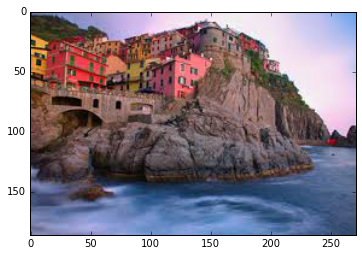

In [286]:
#let's see what images are correctly classified
one=random.choice(good)
plt.imshow(X_test[one])

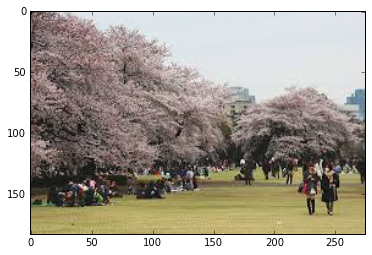

In [246]:
#let's see what images are unclassified
one=random.choice(bad)

plt.imshow(X_test[one])

For the custom kernel part, let us use the so-called **histogram intersection kernel**, described in this <a href=http://slipguru.disi.unige.it/Downloads/publications/icip03.pdf>article by Barla, Odone and Verri</a>. As the paper explains, given two image histograms, it amounts to computing the sum of all minimal bins (see Eq. 6). The article also shows that this is a Mercel kernel (so it can be used in SVMs with theoretical guarantees) and applies it to solve the same problem we are dealing with: distinguishing indoor from outdoor images.

<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td>
Implement a function *histogram_intersection* that computes the histogram intersection kernel.
 </td></tr>
</table>

<table align="left">
 <tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td>
Recall that kernels in scikit-learn receive a (n1, d) matrix and a (n2, d) matrix, returning a (n1, n2) matrix.
 </td></tr>
</table>

In [80]:
def histogram_intersection(data_1,data_2):

    
    kernel = np.zeros((data_1.shape[0], data_2.shape[0]))

    for d in range(data_1.shape[1]):
        column_1 = data_1[:, d].reshape(-1, 1)
        column_2 = data_2[:, d].reshape(-1, 1)
        kernel += np.minimum(column_1, column_2.T)

    return kernel

histogram_intersection(np.array(X_train_hist),np.array(X_train_hist))

array([[ 1.        ,  0.65182367,  0.68799079, ...,  0.6603161 ,
         0.61367759,  0.61653576],
       [ 0.65182367,  1.        ,  0.66422371, ...,  0.73866072,
         0.4453329 ,  0.58652303],
       [ 0.68799079,  0.66422371,  1.        , ...,  0.74791823,
         0.55221584,  0.80211258],
       ..., 
       [ 0.6603161 ,  0.73866072,  0.74791823, ...,  1.        ,
         0.48149249,  0.70397497],
       [ 0.61367759,  0.4453329 ,  0.55221584, ...,  0.48149249,
         1.        ,  0.48380662],
       [ 0.61653576,  0.58652303,  0.80211258, ...,  0.70397497,
         0.48380662,  1.        ]])

<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td>
Tune an SVM with *histogram_intersection* as kernel. Compare the results you obtain with those of the linear and RBF SVMs.
 </td></tr>
</table>

In [81]:
Cs=np.logspace(-2,6,30)

clf = SVC(C=0.01,kernel=histogram_intersection)

mypipeline = Pipeline(steps=[("svm", clf)])


gs= GridSearchCV(mypipeline,
                      param_grid={"svm__C": Cs},                                             
                      scoring="accuracy",
                      cv=5,
                      verbose=2
                      )

gs.fit(np.array(X_train_hist),np.array(y_train))

print(gs.best_params_)

print("Score in traingin=%4.3f" %(gs.score(X_train_hist,y_train)))
print("Score in test=%4.3f" %(gs.score(X_test_hist,y_test)))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] svm__C=0.01 .....................................................


ValueError: X should be a square kernel matrix

<table align="left">
 <tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td>
Due to a buggy behavior of scikit-learn, it is possible that it does not allow you to use an *SVC* with *kernel=histogram_intersection*, prompting you to use a 'precomputed' kernel. If that is the case, you should do the following:
<ol>
<li>Compute and store the kernel matrix in a separate variable.</li>
<li>Build your *SVC* object with *kernel='precomputed'*.</li>
<li>Call the *fit* method with the variable storing the kernel matrix, instead of the one with the training set.</li>
</ol> <br>
Do analogously when evaluating performance on the test set.
 </td></tr>
</table>

In [134]:
best_score_=0
for C in np.logspace(-4,-1,50):
    clf = SVC(C=C,kernel=histogram_intersection)
    clf.fit(X_train_hist,y_train)
    score=clf.score(X_train_hist,y_test)
    if score > best_score_:
        best_score_=score
        best_C=C
print(best_score_,C)

0.535135135135 0.1


In [58]:

kernels_train=histogram_intersection(np.array(X_train_hist),np.array(X_train_hist))

kernels_test=histogram_intersection(np.array(X_test_hist),np.array(X_test_hist))

     

In [94]:
clf = SVC(kernel='precomputed')

Cs_p=np.arange(4,6,0.01)

mypipeline = Pipeline(steps=[("svm", clf)])


gs= GridSearchCV(mypipeline,
                      param_grid={"svm__C": Cs_p},                                             
                      scoring="accuracy",
                      cv=5,
                      verbose=2)

gs.fit(kernels_train,y_train)

print(gs.best_params_)

print("Score in training=%4.3f" %(gs.score(kernels_train,y_train)))
print("Score in test=%4.3f" %(gs.score(kernels_test,y_test)))

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] svm__C=4.0 ......................................................
[CV] ............................................. svm__C=4.0 -   0.0s
[CV] svm__C=4.0 ......................................................
[CV] ............................................. svm__C=4.0 -   0.0s
[CV] svm__C=4.0 ......................................................
[CV] ............................................. svm__C=4.0 -   0.0s
[CV] svm__C=4.0 ......................................................
[CV] ............................................. svm__C=4.0 -   0.0s
[CV] svm__C=4.0 ......................................................
[CV] ............................................. svm__C=4.0 -   0.0s
[CV] svm__C=4.01 .....................................................
[CV] ............................................ svm__C=4.01 -   0.0s
[CV] svm__C=4.01 .....................................................
[CV] ........

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ............................................. svm__C=4.1 -   0.0s
[CV] svm__C=4.1 ......................................................
[CV] ............................................. svm__C=4.1 -   0.0s
[CV] svm__C=4.1 ......................................................
[CV] ............................................. svm__C=4.1 -   0.0s
[CV] svm__C=4.1 ......................................................
[CV] ............................................. svm__C=4.1 -   0.0s
[CV] svm__C=4.1 ......................................................
[CV] ............................................. svm__C=4.1 -   0.0s
[CV] svm__C=4.11 .....................................................
[CV] ............................................ svm__C=4.11 -   0.0s
[CV] svm__C=4.11 .....................................................
[CV] ............................................ svm__C=4.11 -   0.0s
[CV] svm__C=4.11 .....................................................
[CV] .

[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    3.5s finished
/home/bellinsky/anaconda3/lib/python3.5/site-packages/sklearn/grid_search.py:426: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)


<table align="left">
 <tr><td width="80"><img src="img/pro.png" style="width:auto;height:auto"></td><td>
 For the 3 kinds of SVMs above we first transformed the data with *color_frequencies* and then tuned the SVMs. As you know, for the use case where one needs to preprocess the data with some transformations before applying the final estimator, scikit-learn provides the *Pipeline* class. Reimplement the transformation of an image to a color histogram in a way compatible with pipelines. Tune the resulting pipelines for each of the 3 SVMs and verify that you obtain similar results.
 </td></tr>
</table>

<table align="left">
 <tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td>
 You will have to create a class that inherits from *BaseEstimator* and *TransformerMixin*.
 </td></tr>
</table>

In [28]:
from sklearn.base import BaseEstimator, TransformerMixin

def color_frequencies_2(img_list,norm=True):
    
    print("entering color_frequencies_2..")
    
    result_l=[]   
   
    for img in img_list:
    
        red=img[:, :, 0].ravel()
        green=img[:, :, 1].ravel()
        blue=img[:, :, 2].ravel()
        
        red_hist, bin_edges =histogram(red,256)
        green_hist, bin_edges=histogram(green,256)
        blue_hist, bin_edges=histogram(blue,256)
    
        color_hist=[]
        color_hist.append(red_hist)
        color_hist.append(green_hist)
        color_hist.append(blue_hist)
        
        color_hist=np.array(color_hist).ravel()
        
        color_hist_norm=[x/sum(color_hist) for x in color_hist]
        
        if(norm==True):
            result=color_hist_norm
        else:
            result=color_hist
            
        result_l.append(result)
        
    print("exiting color_frequencies..")   
    return np.array(result_l)
    
class Preprocess(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        return

    def transform(self, X, y=None):
        return color_frequencies_2(X)
        
      # some code 

    def fit(self, X, y=None, **fit_params):
        print("fit function..")
        return self

        
  

In [95]:
#linear pipeline

clf = SVC(C=6210.169418915616,kernel='linear')

mypipeline_linear = Pipeline(steps=[("preprocess",Preprocess()), ("svm", clf)])

mypipeline_linear.fit(X_train,y_train)


print("Score in training=%4.3f" %(mypipeline_linear.score(X_train,y_train)))
print("Score in test=%4.3f" %(mypipeline_linear.score(X_test,y_test)))

# we could aslo perfomr a GridSearch after creating the pipeline_linear, but it takes a long time to compute
# gs= GridSearchCV(mypipeline,
#                      param_grid={"svm__C": Cs},                                             
#                      scoring="accuracy",
#                      cv=5,
#                      verbose=2
#                      )
# mypipeline_linear.fit(X_train,y_train)
#
#
# print("Score in training=%4.3f" %(mypipeline_linear.score(X_train,y_train)))
# print("Score in test=%4.3f" %(mypipeline_linear.score(X_test,y_test)))


fit function..
entering color_frequencies_2..
exiting color_frequencies..
entering color_frequencies_2..
exiting color_frequencies..
Score in training=0.908
entering color_frequencies_2..
exiting color_frequencies..
Score in test=0.670


In [179]:
#gaussian kernel

clf = SVC(C= 10000.0, gamma= 0.10000000000000001,kernel='rbf',probability=True)  # set probability tu True to get better images scores

mypipeline_gaussian = Pipeline(steps=[("preprocess",Preprocess()), ("svm", clf)])

mypipeline_gaussian.fit(X_train,y_train) # to get better images scores



print("Score in traingin=%4.3f" %(mypipeline_gaussian.score(X_train,y_train)))
print("Score in test=%4.3f" %(mypipeline_gaussian.score(X_test,y_test)))

fit function..
entering color_frequencies_2..
exiting color_frequencies..
entering color_frequencies_2..
exiting color_frequencies..
Score in traingin=0.886
entering color_frequencies_2..
exiting color_frequencies..
Score in test=0.649


In [110]:
#custom kernel

clf = SVC(C=1000,kernel=histogram_intersection)

mypipeline_custon_kernel = Pipeline(steps=[("preprocess",Preprocess()), ("svm", clf)])


mypipeline_custom_kernel.fit(X_train,y_train)

mypipeline_custom_kernel.get_params

print("Score in training=%4.3f" %(mypipeline_custom_kernel.score(X_train,y_train)))
print("Score in test=%4.3f" %(mypipeline_custom_kernel.score(X_train,y_test)))

fit function..
entering color_frequencies_2..
exiting color_frequencies..
entering color_frequencies_2..
exiting color_frequencies..
Score in training=1.000
entering color_frequencies_2..
exiting color_frequencies..
Score in test=0.443


<table align="left">
 <tr><td width="80"><img src="img/pro.png" style="width:auto;height:auto"></td><td>
 Try to get a grasp of what your SVMs are doing internally by studying the resulting models. For example, it seems reasonable to think that blue (sky, water) or green (trees) are more indicative of outdoor images than indoor ones. Report and justify your findings.
 </td></tr>
</table>

<table align="left">
 <tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td>
 For the linear SVM, you can directly check the influence of the different colors by examining the hyperplane vector in the *coef_* attribute. For the non-linear SVMs, you can examine the support vectors, available in the attributes *support_*, *support\_vectors\_* and *dual\_coef\_*, to see what images are considered as the most representative of each class. Another idea, valid for all SVMs, is to check and detect trends on which test images are clearly classified as outdoor, which as indoor, which are dubious and which are wrongly classified.
 </td></tr>
</table>

In [161]:
best_svm_linear = mypipeline_linear.named_steps['svm']

coef_reshape=best_svm_linear.coef_.reshape(3,256)

index_red=np.argsort(coef_reshape[0])
index_green=np.argsort(coef_reshape[1])
index_blue=np.argsort(coef_reshape[2])

colors=np.column_stack((index_red,index_green,index_blue))

print(colors)


[[141   0   1]
 [ 97 255   2]
 [ 94 253  42]
 [147 252 127]
 [ 86 228   3]
 [192 213 170]
 [ 20   1 123]
 [142  14 214]
 [ 93 207 116]
 [ 21  15  43]
 [ 19 151 134]
 [193 243 106]
 [146 239  47]
 [199  35  27]
 [202 155  44]
 [145 227 120]
 [136 250 113]
 [133 206 124]
 [187 242  40]
 [ 18 196 128]
 [135 216  54]
 [ 87  42   6]
 [132 208  30]
 [164 251  65]
 [ 15 236  41]
 [ 85 230 213]
 [205 240 108]
 [ 82 197 122]
 [236 244  21]
 [149  16 121]
 [122   5  62]
 [156 127  36]
 [214 192 164]
 [194 158 133]
 [ 81 231  22]
 [130  17  18]
 [197  13 131]
 [228  10 162]
 [ 79  20  15]
 [201 241 117]
 [ 22 157  38]
 [180 200  25]
 [ 90 122 125]
 [131 233  75]
 [144 217  45]
 [229   6  32]
 [190 199  37]
 [169  54 105]
 [139 152 115]
 [ 80  36  16]
 [  4   7 118]
 [186  56  58]
 [ 83 238  29]
 [151 237 217]
 [100 198  39]
 [168 210 126]
 [162  66  69]
 [167 121 225]
 [200 205  85]
 [ 84 191 177]
 [163 232  20]
 [134  59  51]
 [ 96  62 107]
 [123 249 119]
 [ 99 195 232]
 [176  38  34]
 [148 161 

In [291]:
best_svm_gaussian=mypipeline_gaussian.named_steps['svm']
support_vectors=best_svm_gaussian.support_vectors_
dual_coef=best_svm_gaussian.dual_coef_

print(support_vectors.shape)
print(dual_coef.shape)
print(dual_coef.argsort().shape)


(138, 768)
(1, 138)
(1, 138)
185


## Part 2: Deep Learning approach

### Preprocessing

<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td>
For efficiency in batch processing, in keras all input patterns should have equal dimensions. Even more, when working with images keras expects as training input a 4-dimensional matrix with dimensions (patterns, image_width, image_height, color_channels). Therefore, you must preprocess the data into this format. It is also highly recommended to rescale the pixel values to make them lie in the range [0,1]. Finally, you might also need to perform some transformation on the outputs Y.
 </td></tr>
</table>

In [12]:
from scipy.misc import imresize

ROWS=50
COLS=50

def transform(x):
    
    x_resized=imresize(x, (ROWS,COLS))              #resize images
    float_image=x_resized.astype('float32') / 255   #transform RGB to float 
   
    return float_image


X_train_dl=[]

for x in X_train:
     X_train_dl.append(transform(x))
    
    
X_test_dl=[]
for x in X_test:
     X_test_dl.append(transform(x))




In [13]:
from keras.utils import np_utils
y_train_dl = np_utils.to_categorical(y_train, 2) 
y_test_dl = np_utils.to_categorical(y_test, 2)

Using TensorFlow backend.


In [14]:
X_train_dl=np.array(X_train_dl)
traintensor = X_train_dl.reshape(len(X_train_dl), ROWS*COLS*3)

X_test_dl=np.array(X_test_dl)
testtensor = X_test_dl.reshape(len(X_test_dl), ROWS*COLS*3)

### Deep model

<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td>
Create a deep network that solves the classification problem. Make use of the layers you seem fit for problem. You are only allowed to use the training split for building the network.
 </td></tr>
</table>

In [15]:
#utils functions to fit and evaluate models

def run(model,optimizer='adam',epochs=20,verbose=0):
    
    print("Optimizer: %s..." % (optimizer))   
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    model.fit(
        traintensor,                             # Training data
        y_train_dl,                              # Labels of training data
        validation_data=(testtensor, y_test_dl), # validation data
        batch_size=128,                          # Batch size for the optimizer algorithm
        nb_epoch=epochs,                         # Number of epochs to run the optimizer algorithm
        verbose=verbose                          # Level of verbosity of the log messages
        )

    return model

def results(model):

    scores=model.evaluate(testtensor,y_test_dl, verbose=0) # checking accuracy against Test
    print("Accuracy: %.2f%%" % (scores[1]*100))    

    return



In [16]:
#simple perceptron 

from keras.models import Sequential
from keras.layers import Dense,Convolution2D,Dropout,Activation,LSTM,Dropout,MaxPooling2D,Flatten

model = Sequential()
denselayer = Dense(2, input_shape=(ROWS*COLS*3,))
model.add(denselayer)
model.add(Activation('softmax'))

model.summary()

run(model,optimizer='adam')
results(model)

run(model,optimizer='sgd')
results(model)


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 2)             15002       dense_input_1[0][0]              
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 2)             0           dense_1[0][0]                    
Total params: 15,002
Trainable params: 15,002
Non-trainable params: 0
____________________________________________________________________________________________________
Optimizer: adam...
Accuracy: 67.20%
Optimizer: sgd...
Accuracy: 51.61%


In [17]:
#two layers model

model = Sequential()
model.add(Dense(100, input_shape=(ROWS*COLS*3,)))
model.add(Activation('sigmoid'))
model.add(Dense(2))
model.add(Activation('softmax'))

model.summary()

model=run(model)
results(model)

model=run(model,optimizer='sgd')
results(model)



____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_2 (Dense)                  (None, 100)           750100      dense_input_2[0][0]              
____________________________________________________________________________________________________
activation_2 (Activation)        (None, 100)           0           dense_2[0][0]                    
____________________________________________________________________________________________________
dense_3 (Dense)                  (None, 2)             202         activation_2[0][0]               
____________________________________________________________________________________________________
activation_3 (Activation)        (None, 2)             0           dense_3[0][0]                    
Total params: 750,302
Trainable params: 750,302
Non-trainable params: 0
___________________

In [18]:
#3 layers model

model = Sequential()
model.add(Dense(512, input_shape=(ROWS*COLS*3,)))
model.add(Activation('relu'))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(2))
model.add(Activation('softmax'))

model.summary()

run(model,optimizer='adam')
results(model)

run(model,optimizer='sgd')
results(model)





____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_4 (Dense)                  (None, 512)           3840512     dense_input_3[0][0]              
____________________________________________________________________________________________________
activation_4 (Activation)        (None, 512)           0           dense_4[0][0]                    
____________________________________________________________________________________________________
dense_5 (Dense)                  (None, 512)           262656      activation_4[0][0]               
____________________________________________________________________________________________________
activation_5 (Activation)        (None, 512)           0           dense_5[0][0]                    
___________________________________________________________________________________________

In [19]:
#4 layers model
model = Sequential()
model.add(Dense(512, input_shape=(ROWS*COLS*3,)))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(2))
model.add(Activation('softmax'))

model.summary()

run(model,optimizer='adam')
results(model)

run(model,optimizer='sgd')
results(model)




____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_7 (Dense)                  (None, 512)           3840512     dense_input_4[0][0]              
____________________________________________________________________________________________________
activation_7 (Activation)        (None, 512)           0           dense_7[0][0]                    
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 512)           0           activation_7[0][0]               
____________________________________________________________________________________________________
dense_8 (Dense)                  (None, 512)           262656      dropout_1[0][0]                  
___________________________________________________________________________________________

In [20]:
#let's try different convolutional networks, we need to rescale our training and test vectors..
traintensor = X_train_dl.reshape(len(X_train_dl), ROWS,COLS,3)
testtensor = X_test_dl.reshape(len(X_test_dl), ROWS,COLS,3)
traintensor.shape

(185, 50, 50, 3)

<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td>
Compute the accuracy of your network over the test set.
 </td></tr>
</table>

In [21]:
from keras.constraints import maxnorm
from keras.optimizers import SGD

# two convolution layers with Maxpooling and stride

model = Sequential()
model.add(Convolution2D(20, 5, 5, input_shape=(ROWS,COLS,3),subsample=(2, 2), border_mode='same', activation='relu', W_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Convolution2D(20, 5, 5, activation='relu',subsample=(2, 2), border_mode='same', W_constraint=maxnorm(3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu', W_constraint=maxnorm(3)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.summary()

model=run(model)
results(model)

model=run(model,optimizer='sgd')
results(model)


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 25, 25, 20)    1520        convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
dropout_3 (Dropout)              (None, 25, 25, 20)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 13, 13, 20)    10020       dropout_3[0][0]                  
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 6, 6, 20)      0           convolution2d_2[0][0]            
___________________________________________________________________________________________

In [22]:
### from keras.constraints import maxnorm
from keras.optimizers import SGD

# Create the model
model = Sequential()
model.add(Convolution2D(30, 5, 5, input_shape=(ROWS,COLS,3),subsample=(2, 2), border_mode='same',  W_constraint=maxnorm(3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Convolution2D(30, 5, 5,subsample=(2, 2), border_mode='same', W_constraint=maxnorm(3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, W_constraint=maxnorm(3)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

epochs = 25

optimizer_l=['adam',
            'sgd',
            'adagrad',
            'adadelta',
            'adamax',
            'nadam',
           ]

model.summary()

for o in optimizer_l:
    model=run(model,optimizer=o,verbose=0,epochs=epochs)
    results(model)


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_3 (Convolution2D)  (None, 25, 25, 30)    2280        convolution2d_input_2[0][0]      
____________________________________________________________________________________________________
activation_10 (Activation)       (None, 25, 25, 30)    0           convolution2d_3[0][0]            
____________________________________________________________________________________________________
maxpooling2d_2 (MaxPooling2D)    (None, 12, 12, 30)    0           activation_10[0][0]              
____________________________________________________________________________________________________
dropout_5 (Dropout)              (None, 12, 12, 30)    0           maxpooling2d_2[0][0]             
___________________________________________________________________________________________

<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td>
Find and show an image for which the model fails. Can you give an explanation for this behavior?
 </td></tr>
</table>

186/186 [==============================] - 0s     


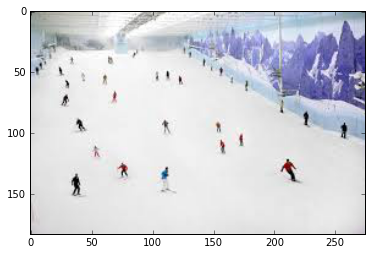

In [25]:
import random

preds = model.predict_classes(testtensor)

diff=np.array(np.where(preds!=y_test)).ravel()

one=random.choice(diff)

plt.imshow(X_test[one])



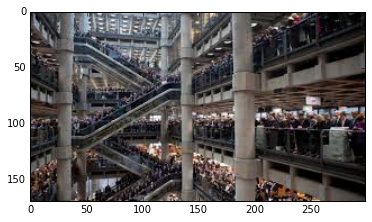

In [26]:
one=random.choice(diff)

plt.imshow(X_test[one])

## Part 3: method comparison

<table align="left">
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td>
Write a small report comparing the results obtained using the two attempted approaches. What are the advantages and disadvantages of each of them?
 </td></tr>
</table>

Resultados:

__GENERAL__

Al ser el dataset muy pequeño, no podiamos esperar grandes resultados. 

__SVM__


la mejor svm es con kernel gaussiano, pero con un score mediocre (65%).

Contrariamente a lo que dice la teoria, el kernel con interseccion de histograma, me da unos resultados muy malos.
Puede ser algun error de implementacion

__REDES NEURONALES__

He observado que trabajar con fotos de gran tamaño no mejora los resultados y mete mucho overhead al cálculo.
Con un tamaño de 50 x 50, se obtienen resultados en el entorno del 80%

De las redes neuronales, las mejores son aquellas con convolucion, es decir, cuando la posicion del pixel es tomada en cuentabtenemos una mejor clasificacion que roza el 80 % con este tipo de redes.


__CONCLUSION__

Ha sido una práctica fantástica. He aprendido mucho y he apuntalado muchos conceptos teóricos.
Quiero mas!!

Un placer haber sido vuestro alumno,

                                                                                           Javier de Juan
